In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


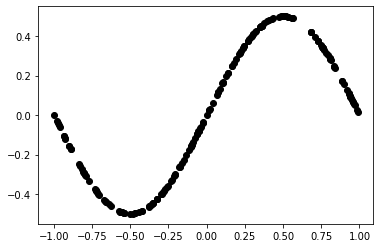

In [101]:
def create_data(N):
    
    x = np.random.uniform(-1, 1, N)
    x = torch.tensor(x).float()
    y = 0.5 * torch.sin(np.pi*x)
    
    z = torch.column_stack((x, y))
    
    return z.detach()



a = create_data(200)

a_np = a.numpy()

plt.plot(a_np[:,0], a_np[:,1], 'ko');



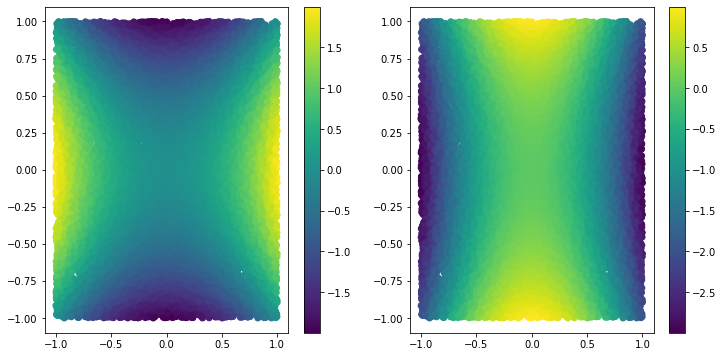

In [3]:

def create_data_2d(N):
    
    a = np.random.uniform(low=-1.0, high=1.0, size=N)
    b = np.random.uniform(low=-1.0, high=1.0, size=N)
    
    x = np.zeros((N, 2))
    x[:,0] = a
    x[:,1] = b
    
    z = np.zeros_like(x)
    z[:,0] = 2*x[:,0]**2 - 2*x[:,1]**2
    z[:,1] = -3*x[:,0]**2 + x[:,1]**2
    
    x = torch.tensor(x).float()
    z = torch.tensor(z).float()
    
    return x, z

data2d = create_data_2d(16000)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
splot_0 = ax[0].scatter(data2d[0][...,0], data2d[0][...,1], c=data2d[1][...,0]);
plt.colorbar(splot_0, ax=ax[0])
splot_1 = ax[1].scatter(data2d[0][...,0], data2d[0][...,1], c=data2d[1][...,1]);
plt.colorbar(splot_1, ax=ax[1]);


In [94]:

from torch import nn

class ResidualNetwork(nn.Module):
    
    def __init__(self, width, depth, activation=nn.Tanh(), 
                 activation_diff=lambda x: 1 / torch.cosh(x)**2):
        super(ResidualNetwork, self).__init__()
        
        self.width = width
        self.depth = depth
        
        self.delta_t = 1.0
        
        linear_layers = [nn.Linear(width, width) for _ in range(depth)]
        self.W = torch.nn.ParameterList([l.weight for l in linear_layers])
        self.b = nn.ParameterList([l.bias for l in linear_layers])
        
        self.sigma = activation
        self.dsigma = activation_diff
        
        return
    
        
    def forward(self, x):
        
        y = x
        for W, b in zip(self.W, self.b):
            # y = y + dt * sigma(W @ y + b)
            y = y + self.delta_t * self.sigma(torch.matmul(W[None,...], y[...,None])[...,0] + b)
        
        return y
    
    
    def train_non_batch(self, x, z, loss_grad, lr):
        
        for par in self.parameters():
            par.requires_grad = False
        
        yy = torch.zeros((self.depth+1, *x.shape))
        pp = torch.zeros((self.depth+1, *x.shape))
        
        """ Computing state """
        y = x
        yy[0,:] = y
        
        for k in range(self.depth):
            W, b = self.W[k], self.b[k]
            y = y + self.delta_t * self.sigma(W @ y + b)
            yy[k+1,:] = y
            
        p_end = loss_grad(y, z)
        
        """ Computing adjoint """
        p = p_end
        pp[-1,:] = p
        
        for k in range(self.depth, 0, -1):
            W, b = self.W[k-1], self.b[k-1]
            y = yy[k-1,:]
            p = p + self.delta_t * W.T @ torch.diag( self.dsigma(W @ y + b) ) @ p
            pp[k-1,:] = p
            
        grad_W = torch.zeros((self.depth+1, x.shape[0], x.shape[0]))
        grad_b = torch.zeros((self.depth+1, *x.shape))
        
        """ Computing gradients and updating control """        
        for k in range(self.depth):
            
            W, b, y, p = self.W[k], self.b[k], yy[k,:], pp[k+1,:]
        
            grad_W[k] = torch.diag( self.dsigma(W @ y + b) ) @ ( p[:,None] * y[None,:] )
            grad_b[k] = torch.diag( self.dsigma(W @ y + b) ) @ p
            
            self.W[k] -= lr * grad_W[k]
            self.b[k] -= lr * grad_b[k]
        
        for par in self.parameters():
            par.requires_grad = False
        
        return grad_W, grad_b
    
    
    def check_optimality_condition(self, x, z, loss_grad):
        
        for par in self.parameters():
            par.requires_grad = False
        
        yy = torch.zeros((self.depth+1, *x.shape))
        pp = torch.zeros((self.depth+1, *x.shape))
        
        """ Computing state """
        y = x
        yy[0,:] = y
        
        for k in range(self.depth):
            W, b = self.W[k], self.b[k]
            y = y + self.delta_t * self.sigma(W @ y + b)
            yy[k+1,:] = y
            
        p_end = loss_grad(y, z)
        
        """ Computing adjoint """
        p = p_end
        pp[-1,:] = p
        
        for k in range(self.depth, 0, -1):
            W, b = self.W[k-1], self.b[k-1]
            y = yy[k-1,:]
            p = p + self.delta_t * W.T @ torch.diag( self.dsigma(W @ y + b) ) @ p
            pp[k-1,:] = p
            
        grad_W = torch.zeros((self.depth+1, x.shape[0], x.shape[0]))
        grad_b = torch.zeros((self.depth+1, *x.shape))
        
        opt_cond_norms = np.zeros(self.depth)
        
        """ Computing gradients and updating control """
        for k in range(self.depth):
            
            W, b, y, p = self.W[k], self.b[k], yy[k,:], pp[k+1,:]
            
            val = torch.diag( self.dsigma(W @ y + b) ) @ p            
            opt_cond_norms[k] = np.linalg.norm(val.detach().numpy())
            
        for par in self.parameters():
            par.requires_grad = False
        
        
        return opt_cond_norms
    


In [128]:
np.random.seed(seed=0)
torch.manual_seed(0)

width = 1
depth = 10

resnet = ResidualNetwork(width, depth)

data = create_data(50)
x = data[:,[0]]
z = data[:,[1]]

loss_fn = lambda y, z: 0.5 * (y-z)**2
loss_grad = lambda y, z: y - z

epochs = 100
lr = 0.1
losses_1D = []
for t in range(epochs):
    loss = torch.sum(loss_fn(resnet(x), z)).item()
    losses_1D.append(loss)
    if ( 10*t ) % epochs < ( 10*(t-1) ) % epochs:
        print(f"epoch #: {t}, loss = {loss}")
    for xz in data:
        x, z = xz[[0]], xz[[1]]
        resnet.train_non_batch(x, z, loss_grad, lr)
print(f"End loss: {loss}")

opt_cond_vals_1D = resnet.check_optimality_condition(x, z, loss_grad)


epoch #: 0, loss = 4.486268997192383
epoch #: 10, loss = 0.016640814021229744
epoch #: 20, loss = 0.020836012437939644
epoch #: 30, loss = 0.002682877006009221
epoch #: 40, loss = 0.000201259259483777
epoch #: 50, loss = 4.526891279965639e-05
epoch #: 60, loss = 2.2224166968953796e-05
epoch #: 70, loss = 1.653742219787091e-05
epoch #: 80, loss = 1.4920741705282126e-05
epoch #: 90, loss = 1.452132983104093e-05
End loss: 1.4527433449984528e-05


In [129]:

"""Saving model"""

folder = "RNasOC-1D"
filename = "RNasOC_1D"
torch.save(resnet.state_dict(), folder+"/"+filename+".pth")
print(f"Saved PyTorch Model State to {folder+'/'+filename}.pth")


Saved PyTorch Model State to saved_models/RNasOC_1D.pth


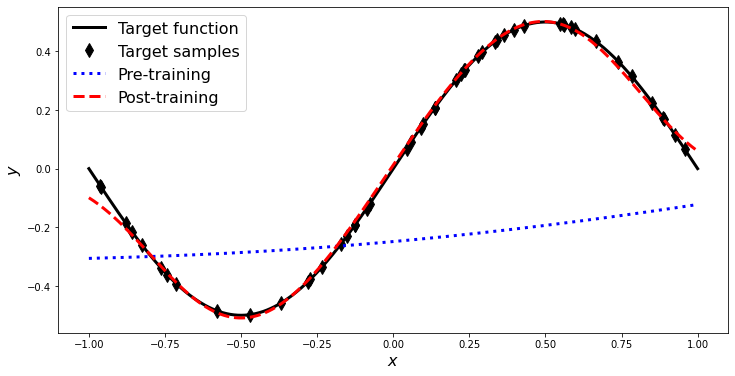

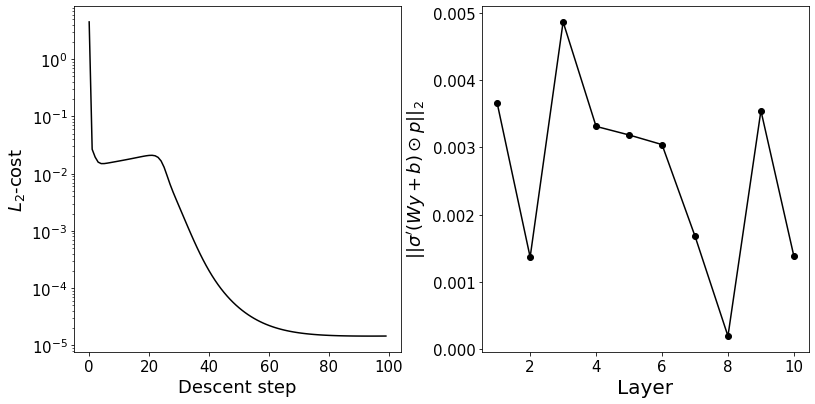

In [130]:
np.random.seed(seed=0)
torch.manual_seed(0)

width = 1
depth = 10

resnet = ResidualNetwork(width, depth)

data = create_data(50)

N = 500
x = np.linspace(-1, 1, N)
z = 0.5 * np.sin(np.pi*x)

y = resnet(torch.tensor(x[:,None]).float()[:,[0]]).detach().numpy()


fig = plt.figure(figsize=(12,6))

plt.plot(x, z, 'k-', label="Target function", lw=3)
plt.plot(data[:,0], data[:,1], 'kd', label="Target samples", ms=10)
plt.plot(x, y, 'b:', label="Pre-training", lw=3)


"""Loading model"""
folder = "RNasOC_1D"
filename = "RNasOC_1D"
resnet.load_state_dict(torch.load(folder+"/"+filename+".pth"))

y = resnet(torch.tensor(x[:,None]).float()[:,[0]]).detach().numpy()


plt.plot(x, y, 'r--', label="Post-training", lw=3);

plt.legend(fontsize=16);
plt.xlabel("$x$", fontsize=16);
plt.ylabel("$y$", fontsize=16);

plt.savefig("RNasOC-1D/truth_pre_post_1D.png", dpi=100)


fig, ax = plt.subplots(1, 2, figsize=(12,6))
fig.subplots_adjust(top=0.92, bottom=0.12, left=0.1, right=0.95, wspace=0.25)


ax[0].semilogy(range(len(losses_1D)), losses_1D, 'k-');
ax[0].set_xlabel("Descent step", fontsize=18)
ax[0].set_ylabel("$L_2$-cost", fontsize=18);
ax[0].tick_params(axis='both', which='major', labelsize=15)


ax[1].plot(range(1,len(opt_cond_vals_1D)+1), opt_cond_vals_1D, 'k-o')
ax[1].set_xlabel("Layer", fontsize=20)
ax[1].set_ylabel("$||\sigma'(Wy +b) \odot p||_2$", fontsize=18);
ax[1].tick_params(axis='both', which='major', labelsize=15);
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].yaxis.offsetText.set_fontsize(15)

fig.savefig("RNasOC-1D/conv_opt_1D.png", dpi=100)



In [131]:
np.random.seed(seed=0)
torch.manual_seed(0)

width = 2
depth = 10

resnet = ResidualNetwork(width, depth)

data = create_data_2d(1000)
x = data[0]
z = data[1]


loss_fn = lambda y, z: 0.5 * ((y-z)**2).sum()
loss_grad = lambda y, z: y - z


epochs = 10
lr = 0.01
losses_2D = []
for t in range(epochs):
    loss = torch.sum(loss_fn(resnet(x), z)).item()
    losses_2D.append(loss)
    if t % (epochs / 5) == 0:
        print(f"epoch #: {t}, loss = {loss}")
    for i in range(x.shape[0]):
        x_i = x[i,:]
        z_i = z[i,:]
        resnet.train_non_batch(x_i, z_i, loss_grad, lr)

epochs = 25
lr = 0.005
for t in range(t+1, t+1+epochs):
    loss = torch.sum(loss_fn(resnet(x), z)).item()
    losses_2D.append(loss)
    if t % (epochs / 5) == 0:
        print(f"epoch #: {t}, loss = {loss}")
    for i in range(x.shape[0]):
        x_i = x[i,:]
        z_i = z[i,:]
        resnet.train_non_batch(x_i, z_i, loss_grad, lr)
        
epochs = 25
lr = 0.003
for t in range(t+1, t+1+epochs):
    loss = torch.sum(loss_fn(resnet(x), z)).item()
    losses_2D.append(loss)
    if t % (epochs / 5) == 0:
        print(f"epoch #: {t}, loss = {loss}")  
    for i in range(x.shape[0]):
        x_i = x[i,:]
        z_i = z[i,:]
        resnet.train_non_batch(x_i, z_i, loss_grad, lr)

print(f"End loss: {loss}")



epoch #: 0, loss = 1094.553955078125
epoch #: 2, loss = 204.73509216308594
epoch #: 4, loss = 72.07023620605469
epoch #: 6, loss = 60.77176284790039
epoch #: 8, loss = 54.770240783691406
epoch #: 10, loss = 45.33952331542969
epoch #: 15, loss = 16.59050750732422
epoch #: 20, loss = 12.15632438659668
epoch #: 25, loss = 10.004180908203125
epoch #: 30, loss = 8.6566801071167
epoch #: 35, loss = 7.688205718994141
epoch #: 40, loss = 6.1369547843933105
epoch #: 45, loss = 5.6900410652160645
epoch #: 50, loss = 5.325737476348877
epoch #: 55, loss = 5.019640922546387
End loss: 4.807054042816162


In [132]:

"""Saving model"""

folder = "RNasOC-2D"
filename = "RNasOC_2D"
torch.save(resnet.state_dict(), folder+"/"+filename+".pth")
print(f"Saved PyTorch Model State to {folder+'/'+filename}.pth")



Saved PyTorch Model State to saved_models/RNasOC_2D.pth


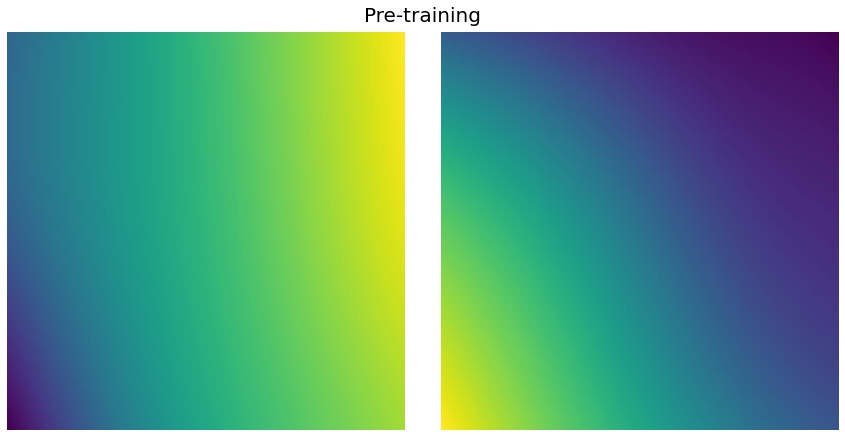

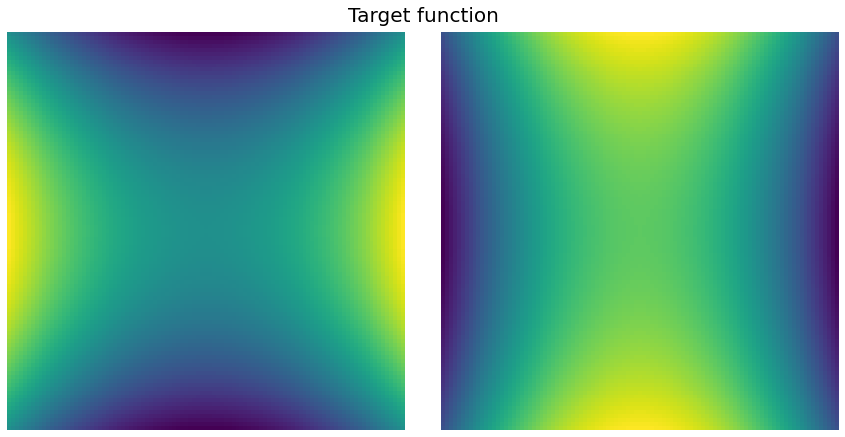

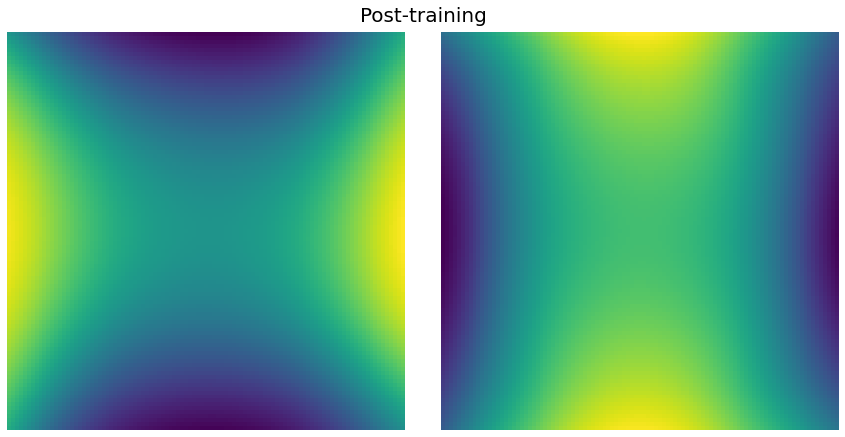

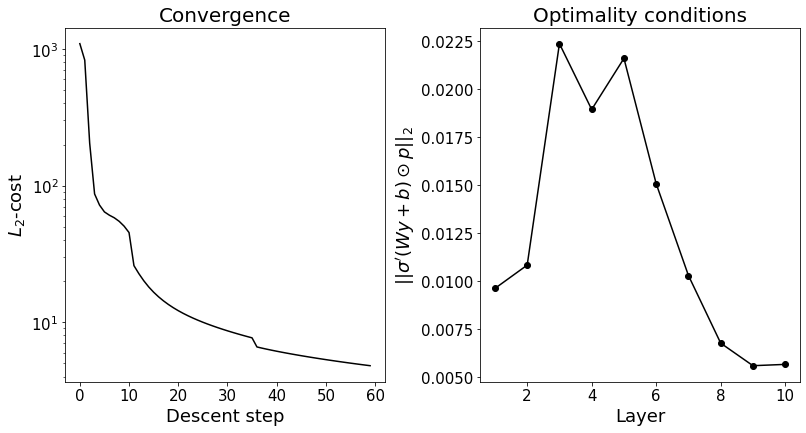

In [133]:

    
np.random.seed(seed=0)
torch.manual_seed(0)

width = 2
depth = 10

resnet = ResidualNetwork(width, depth)

data = create_data_2d(1000)
x = data[0]
z = data[1]
    
N = 101
r_test = np.linspace(-1, 1, N)
x_test = np.zeros((N,N,2))
x_test[:,:,0] = r_test[None,:] * np.ones_like(r_test)[:,None]
x_test[:,:,1] = r_test[:,None] * np.ones_like(r_test)[None,:]

x_test = x_test.reshape(-1,2)

z_test = np.zeros_like(x_test)
z_test[:,0] = 2*x_test[:,0]**2 - 2*x_test[:,1]**2
z_test[:,1] = -3*x_test[:,0]**2 + x_test[:,1]**2

y_test = resnet(torch.tensor(x_test).float()).detach().numpy()



fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.01, top=0.92, bottom=0.0, left=0.0, right=1.0)
fig.suptitle("Pre-training", fontsize=20)
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(y_test[:,0].reshape(N,N))
ax[1].imshow(y_test[:,1].reshape(N,N))
fig.savefig("RNasOC-2D/pre_train_2D.png", dpi=100)


fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.01, top=0.92, bottom=0.0, left=0.0, right=1.0)
fig.suptitle("Target function", fontsize=20)
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(z_test[:,0].reshape(N,N))
ax[1].imshow(z_test[:,1].reshape(N,N))
fig.savefig("RNasOC-2D/ground_truth_2D.png", dpi=100)


"""Loading model"""

folder = "RNasOC-2D"
filename = "RNasOC_2D"
resnet.load_state_dict(torch.load(folder+"/"+filename+".pth"))


y_test = resnet(torch.tensor(x_test).float()).detach().numpy()



fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.01, top=0.92, bottom=0.0, left=0.0, right=1.0)
fig.suptitle("Post-training", fontsize=20)
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(y_test[:,0].reshape(N,N))
ax[1].imshow(y_test[:,1].reshape(N,N))
fig.savefig("RNasOC-2D/post_train_2D.png", dpi=100)


opt_cond_vals_2D = resnet.check_optimality_condition(x_i, z_i, loss_grad)

fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.95, wspace=0.3)

ax[0].semilogy(range(len(losses_2D)), losses_2D, 'k-');
ax[0].set_xlabel("Descent step", fontsize=18)
ax[0].set_ylabel("$L_2$-cost", fontsize=18);
ax[0].set_title("Convergence", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15);

ax[1].plot(range(1,len(opt_cond_vals_2D)+1), opt_cond_vals_2D, 'k-o')
ax[1].set_xlabel("Layer", fontsize=18)
ax[1].set_ylabel("$||\sigma'(Wy +b) \odot p||_2$", fontsize=18);
ax[1].set_title("Optimality conditions", fontsize=20);
ax[1].tick_params(axis='both', which='major', labelsize=15);


fig.savefig("RNasOC-2D/conv_opt_2D.png", dpi=100)
